In [1]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import norm
from time import time
import os
import sys
from os.path import join, abspath
parent_dir = os.path.dirname(os.getcwd())
root_dir =abspath(join(parent_dir, ".."))
sys.path.append(root_dir)
from mcmc import no
from mcmc import utils
from tqdm import tqdm

/home/alisyaifudin/anaconda3/envs/maturin/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
utils.style("seaborn-v0_8-deep")

## tes potential

In [3]:
rhob = [0.0104, 0.0277, 0.0073, 0.0005, 0.0006, 0.0018,0.0018, 0.0029, 0.0072, 0.0216, 0.0056, 0.0015]
e_rhob = [0.00312, 0.00554, 0.00070, 0.00003, 0.00006, 0.00018, 0.00018, 0.00029, 0.00072, 0.00280,0.00100, 0.00050]
sigmaz = [3.7, 7.1, 22.1, 39.0, 15.5, 7.5, 12.0, 18.0, 18.5, 18.5, 20.0, 20.0]
e_sigmaz = [0.2, 0.5, 2.4, 4.0, 1.6, 2.0, 2.4, 1.8, 1.9, 4.0, 5.0, 5.0]
log_nu0 = [-3]
R = [3.4E-3]
zsun = [0]
w0 = [-7]
log_sigmaw1 = [2]
log_a1 = [0]
log_sigmaw2 = [5]
log_a2 = [-2]

theta = np.array([rhob + sigmaz + log_nu0 + R + zsun + w0+ log_sigmaw1 + log_a1+log_sigmaw2 + log_a2]).flatten()
theta.shape

(32,)

In [4]:
z_start = -1000
z_end = 1000
dz = 1.

z = np.arange(z_start, z_end, dz)
print(z)
phi = no.potential(z, theta)

[-1000.  -999.  -998. ...   997.   998.   999.]


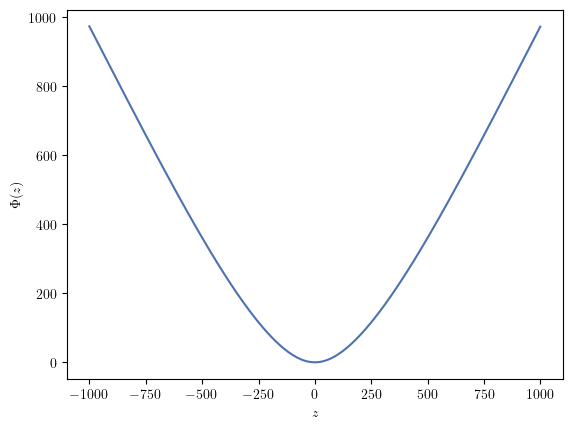

In [5]:
plt.plot(z, phi)
plt.xlabel(r'$z$')
plt.ylabel(r'$\Phi(z)$')
plt.show()

# tes fz

In [6]:
fz = no.fz(z, theta)
fz

array([0.00567814, 0.00567847, 0.0056788 , ..., 0.00567912, 0.0056788 ,
       0.00567847])

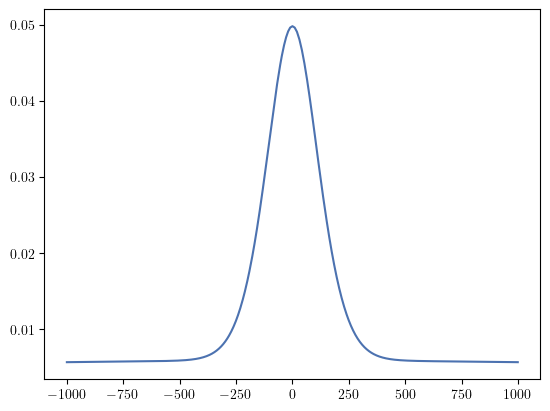

In [7]:
plt.plot(z, fz)

# tes fw

In [8]:
w = np.linspace(-50, 30, 1000)

fw = no.fw(w, theta)
fw.shape

(1000,)

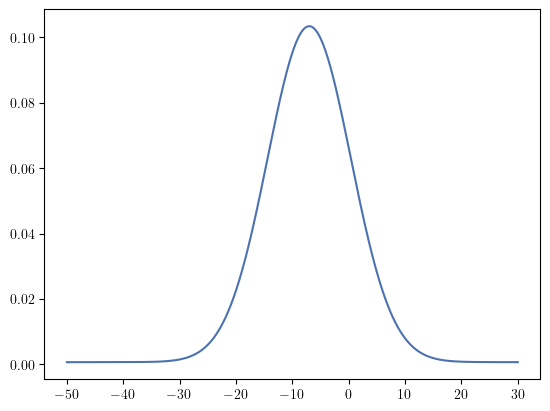

In [9]:
plt.plot(w, fw)

# tes log_prob

In [10]:
rhob = [0.0104, 0.0277, 0.0073, 0.0005, 0.0006, 0.0018,0.0018, 0.0029, 0.0072, 0.0216, 0.0056, 0.0015]
e_rhob = [0.00312, 0.00554, 0.00070, 0.00003, 0.00006, 0.00018, 0.00018, 0.00029, 0.00072, 0.00280,0.00100, 0.00050]
sigmaz = [3.7, 7.1, 22.1, 39.0, 15.5, 7.5, 12.0, 18.0, 18.5, 18.5, 20.0, 20.0]
e_sigmaz = [0.2, 0.5, 2.4, 4.0, 1.6, 2.0, 2.4, 1.8, 1.9, 4.0, 5.0, 5.0]
log_nu0 = [-3]
R = [3.4E-3]
zsun = [0]
w0 = [-7]
log_sigmaw1 = [2]
log_a1 = [0]
log_sigmaw2 = [5]
log_a2 = [-2]

theta = np.array([rhob + sigmaz + log_nu0 + R + zsun + w0+ log_sigmaw1 + log_a1+log_sigmaw2 + log_a2]).flatten()
theta.shape

(32,)

In [12]:
zdata = np.loadtxt(join(parent_dir, 'data', 'z2.csv'), skiprows=1, delimiter=',')
zmid = zdata[:, 0]
znum = zdata[:, 1]
zerr = zdata[:, 2]

wdata = np.loadtxt(join(parent_dir, 'data', 'w2.csv'), skiprows=1, delimiter=',')
wmid = wdata[:, 0]
wnum = wdata[:, 1]
werr = wdata[:, 2]

zdata = (zmid, znum, zerr)
wdata = (wmid, wnum, werr)

In [13]:
from scipy.optimize import curve_fit

In [14]:
def gauss(x, mu, sigma, A):
    return A * norm.pdf(x, mu, sigma)

def kind1():
    poptz, _ = curve_fit(gauss, zmid, znum, p0=[0, 100, 1])
    poptw, _ = curve_fit(gauss, wmid, wnum, p0=[0, 10, 1])

    log_nu0 = np.log(poptz[2]/(np.sqrt(2*np.pi)*poptz[1]))
    log_sigmaw1 = np.log(poptw[1])
    log_a1 = np.log(poptw[2])

    locs = dict(
        log_nu0=log_nu0-1,
        R=3.4E-3,
        zsun=-50,
        w0=-10,
        log_sigmaw1=log_sigmaw1-1,
        log_a1=log_a1-1,
    )

    scales = dict(
        log_nu0=2,
        R=0.6E-3,
        zsun=100,
        w0=5,
        log_sigmaw1=2,
        log_a1=2,
    )
    return locs, scales

def dgauss(x, mu, sigma1, A1, sigma2, A2):
    return A1 * norm.pdf(x, mu, sigma1) + A2 * norm.pdf(x, mu, sigma2)
def kind2():
    while True:
        p0 = np.array([0])
        sigma = np.random.uniform(1, 20, size=2)
        a = np.min(sigma)/sigma
        p0 = np.append(p0, sigma)
        p0 = np.append(p0, a)
        try:
            poptz, _ = curve_fit(gauss, zmid, znum, p0=[0, 100, 1])
            poptw, _ = curve_fit(dgauss, wmid, wnum, p0=p0)
            log_nu0 = np.log(poptz[2]/(np.sqrt(2*np.pi)*poptz[1]))
            log_sigmaw1 = np.log(poptw[1])
            log_a1 = np.log(poptw[2])
            log_sigmaw2 = np.log(poptw[3])
            log_a2 = np.log(poptw[4])
            if np.isnan(log_a1) or np.isnan(log_a2):
                continue
            locs = dict(
                log_nu0=log_nu0-1,
                R=3.4E-3,
                zsun=-50,
                w0=-10,
                log_sigmaw1=log_sigmaw1-1,
                log_a1=log_a1-1.5,
                log_sigmaw2=log_sigmaw2-1,
                log_a2=log_a2-1.5,
            )

            scales = dict(
                log_nu0=2,
                R=0.6E-3,
                zsun=100,
                w0=5,
                log_sigmaw1=2,
                log_a1=3,
                log_sigmaw2=2,
                log_a2=3,
            )
            
            return locs, scales
        except RuntimeError:
            print("RuntimeError, try again...")
            continue

In [16]:
locs, scales = kind2()
keys = list(locs.keys())
locs = np.array(list(locs.values()))
scales = np.array(list(scales.values()))

[(k, loc, th, s+loc) for k, loc, th, s in zip(keys, locs, theta[24:], scales)]

[('log_nu0', -2.1112380376433615, -3.0, -0.11123803764336149),
 ('R', 0.0034, 0.0034, 0.004),
 ('zsun', -50.0, 0.0, 50.0),
 ('w0', -10.0, -7.0, -5.0),
 ('log_sigmaw1', 1.4809617531347055, 2.0, 3.4809617531347055),
 ('log_a1', -2.3327756271120514, 0.0, 0.6672243728879486),
 ('log_sigmaw2', 0.5751063631675837, 5.0, 2.575106363167584),
 ('log_a2', -0.8194952686093941, -2.0, 2.180504731390606)]

In [17]:
no.log_prob(np.array([theta]), zdata, wdata, locs, scales)

(array([-inf]), array([-inf]))

# mcmc

In [18]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import norm
from time import time
import os
import sys
from os.path import join, abspath
parent_dir = os.path.dirname(os.getcwd())
root_dir =abspath(join(parent_dir, ".."))
sys.path.append(root_dir)
from mcmc import no
from mcmc import utils
from tqdm import tqdm
utils.style("seaborn-v0_8-deep")

In [19]:
zdata = np.loadtxt(join(parent_dir, 'data', 'z1.csv'), skiprows=1, delimiter=',')
zmid = zdata[:, 0]
znum = zdata[:, 1]
zerr = zdata[:, 2]

wdata = np.loadtxt(join(parent_dir, 'data', 'w1.csv'), skiprows=1, delimiter=',')
wmid = wdata[:, 0]
wnum = wdata[:, 1]
werr = wdata[:, 2]

zdata = (zmid, znum, zerr)
wdata = (wmid, wnum, werr)

In [20]:
rhob = [0.0104, 0.0277, 0.0073, 0.0005, 0.0006, 0.0018,0.0018, 0.0029, 0.0072, 0.0216, 0.0056, 0.0015]
e_rhob = [0.00312, 0.00554, 0.00070, 0.00003, 0.00006, 0.00018, 0.00018, 0.00029, 0.00072, 0.00280,0.00100, 0.00050]
sigmaz = [3.7, 7.1, 22.1, 39.0, 15.5, 7.5, 12.0, 18.0, 18.5, 18.5, 20.0, 20.0]
e_sigmaz = [0.2, 0.5, 2.4, 4.0, 1.6, 2.0, 2.4, 1.8, 1.9, 4.0, 5.0, 5.0]
log_nu0 = [-3]
R = [3.4E-3]
zsun = [0]
w0 = [-7]
log_sigmaw1 = [2]
log_a1 = [0]
log_sigmaw2 = [5]
log_a2 = [-2]

theta = np.array([rhob + sigmaz + log_nu0 + R + zsun + w0+ log_sigmaw1 + log_a1+log_sigmaw2 + log_a2]).flatten()
theta.shape

(32,)

In [21]:
ndim = 32
nwalkers = 2*ndim+2
nsteps = 10

In [23]:
p0 = no.generate_p0(nwalkers, locs, scales, kind=2)
p0.shape

(66, 32)

In [24]:
no.log_prob(p0, zdata, wdata, locs, scales)

(array([42.61178211, 46.24037045, 46.24400097, 47.15609161, 48.60191323,
        50.63861155, 49.73351544, 45.82884178, 42.63306237, 45.78322458,
        42.14277985, 46.64559057, 47.07472268, 46.10067719, 48.63457837,
        40.77263561, 41.89686246, 48.13324319, 48.89600204, 48.63736497,
        44.61808315, 47.63948066, 49.38421298, 47.00623963, 46.24749282,
        52.06513219, 40.75638806, 49.12569755, 46.10845097, 43.28411827,
        39.60887073, 47.49597026, 45.47586608, 47.40313145, 40.12448377,
        44.59153715, 49.33088722, 42.57845866, 46.16137566, 50.15424525,
        46.83883065, 46.05373474, 51.20173817, 47.73171621, 44.94854914,
        47.24493021, 47.09692826, 40.75387668, 47.17804927, 48.82781765,
        47.62975655, 43.09661211, 42.08384806, 44.22895177, 48.00853105,
        43.72274435, 44.74109868, 42.18662474, 43.64489064, 47.14683457,
        43.57563936, 50.09152364, 47.97773292, 45.37975443, 38.79701116,
        46.13555293]),
 array([ -12026.28984683,  -

(32,)


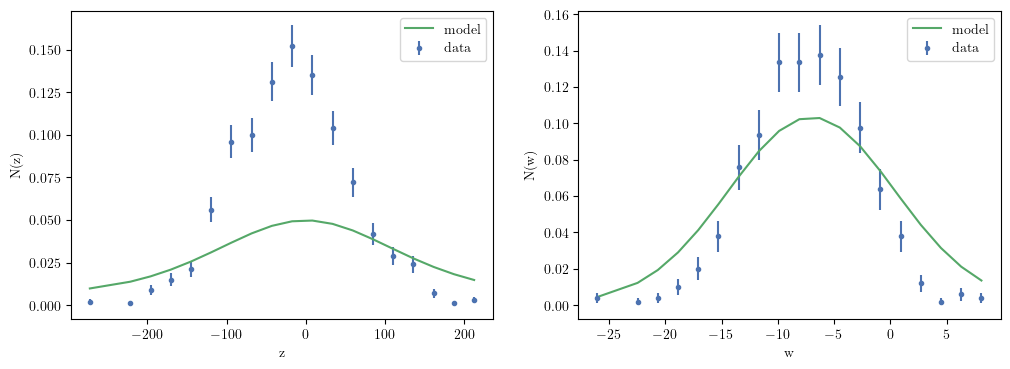

(array([-inf]), array([-inf]))

In [26]:
print(theta.shape)
zmod = no.fz(zmid, theta)
wmod = no.fw(wmid, theta)

# plot
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].errorbar(zmid, znum, yerr=zerr, fmt='.', label='data')
ax[0].plot(zmid, zmod, label='model')
ax[0].set_xlabel('z')
ax[0].set_ylabel('N(z)')
ax[0].legend()
ax[1].errorbar(wmid, wnum, yerr=werr, fmt='.', label='data')
ax[1].plot(wmid, wmod, label='model')
ax[1].set_xlabel('w')
ax[1].set_ylabel('N(w)')
ax[1].legend()
plt.show()
no.log_prob(np.array([theta]), zdata, wdata, locs, scales)

In [30]:
t0 = time()
sampler = no.run_mcmc(500, nwalkers, p0, zdata, wdata, locs, scales, dz=1, verbose=True)
print(time() - t0, "s")
chain, probs = sampler[:,:,:-3], sampler[:,:,-3:]

27.78449583053589 s
Acceptance rate: 0.25681818181818183


 18%|█▉        | 92/500 [00:04<00:21, 19.39it/s]

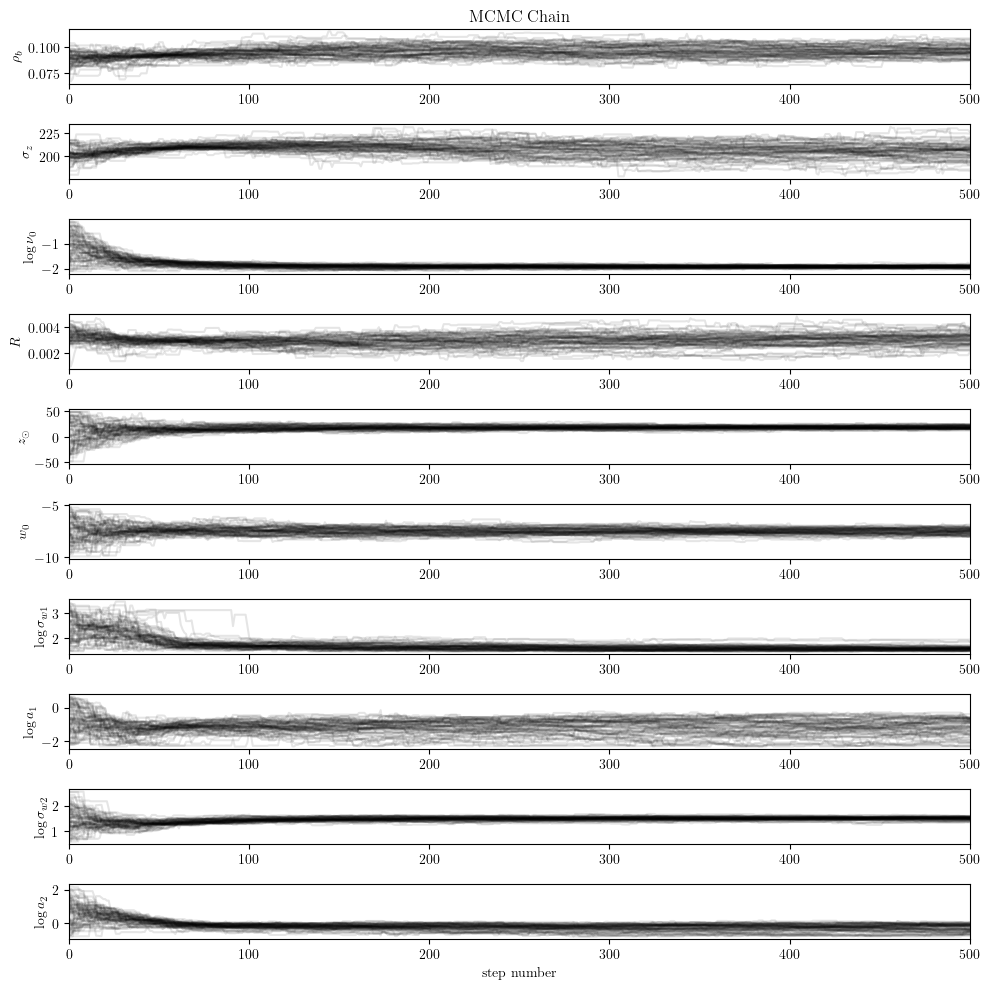

In [31]:
rhob = chain[:, :, :12].sum(axis=2).T
sigmaz = chain[:, :, 12:24].sum(axis=2).T
nu0 = chain[:, :, 24].T
R = chain[:, :, 25].T
zsun = chain[:, :, 26].T
w0 = chain[:, :, 27].T
log_sigmaw1 = chain[:, :, 28].T
log_a1 = chain[:, :, 29].T
log_sigmaw2 = chain[:, :, 30].T
log_a2 = chain[:, :, 31].T

params = np.array([rhob, sigmaz, nu0, R, zsun, w0, log_sigmaw1, log_a1, log_sigmaw2, log_a2]).T

labels = labels = [r'$\rho_b$', r'$\sigma_z$', r'$\log \nu_0$', r'$R$', r'$z_{\odot}$', r'$w_0$', r'$\log \sigma_{w1}$', r'$\log a_1$', r'$\log \sigma_{w2}$', r'$\log a_2$']
utils.plot_chain(params, labels)

In [32]:
p0_next = chain[-1, :, :]
t0 = time()
sampler = no.run_mcmc(1000, nwalkers, p0_next, zdata, wdata, locs, scales, dz=1, verbose=True)
print(time() - t0, "s")
chain, probs = sampler[:,:,:-3], sampler[:,:,-3:]

Acceptance rate: 0.20977272727272728
51.79957151412964 s


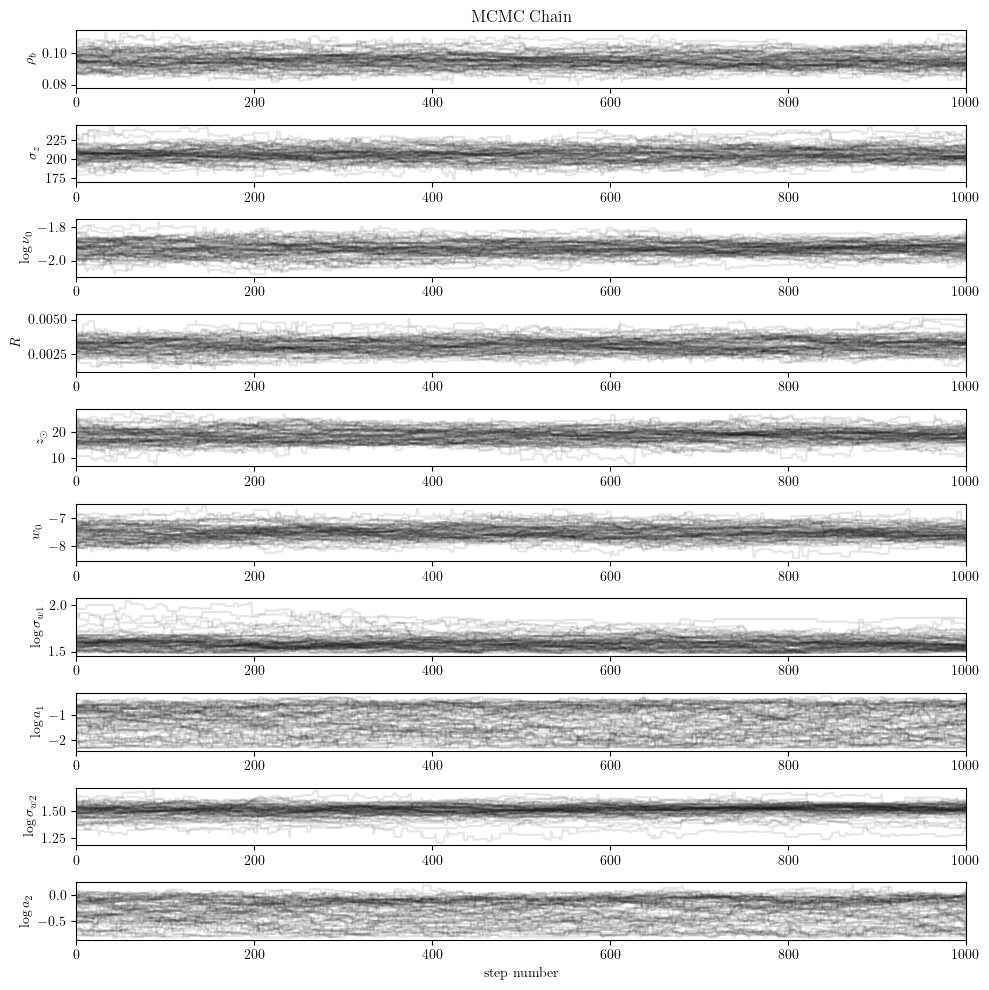

In [33]:
rhob = chain[:, :, :12].sum(axis=2).T
sigmaz = chain[:, :, 12:24].sum(axis=2).T
nu0 = chain[:, :, 24].T
R = chain[:, :, 25].T
zsun = chain[:, :, 26].T
w0 = chain[:, :, 27].T
log_sigmaw1 = chain[:, :, 28].T
log_a1 = chain[:, :, 29].T
log_sigmaw2 = chain[:, :, 30].T
log_a2 = chain[:, :, 31].T

params = np.array([rhob, sigmaz, nu0, R, zsun, w0, log_sigmaw1, log_a1, log_sigmaw2, log_a2]).T

labels = labels = [r'$\rho_b$', r'$\sigma_z$', r'$\log \nu_0$', r'$R$', r'$z_{\odot}$', r'$w_0$', r'$\log \sigma_{w1}$', r'$\log a_1$', r'$\log \sigma_{w2}$', r'$\log a_2$']
utils.plot_chain(params, labels)

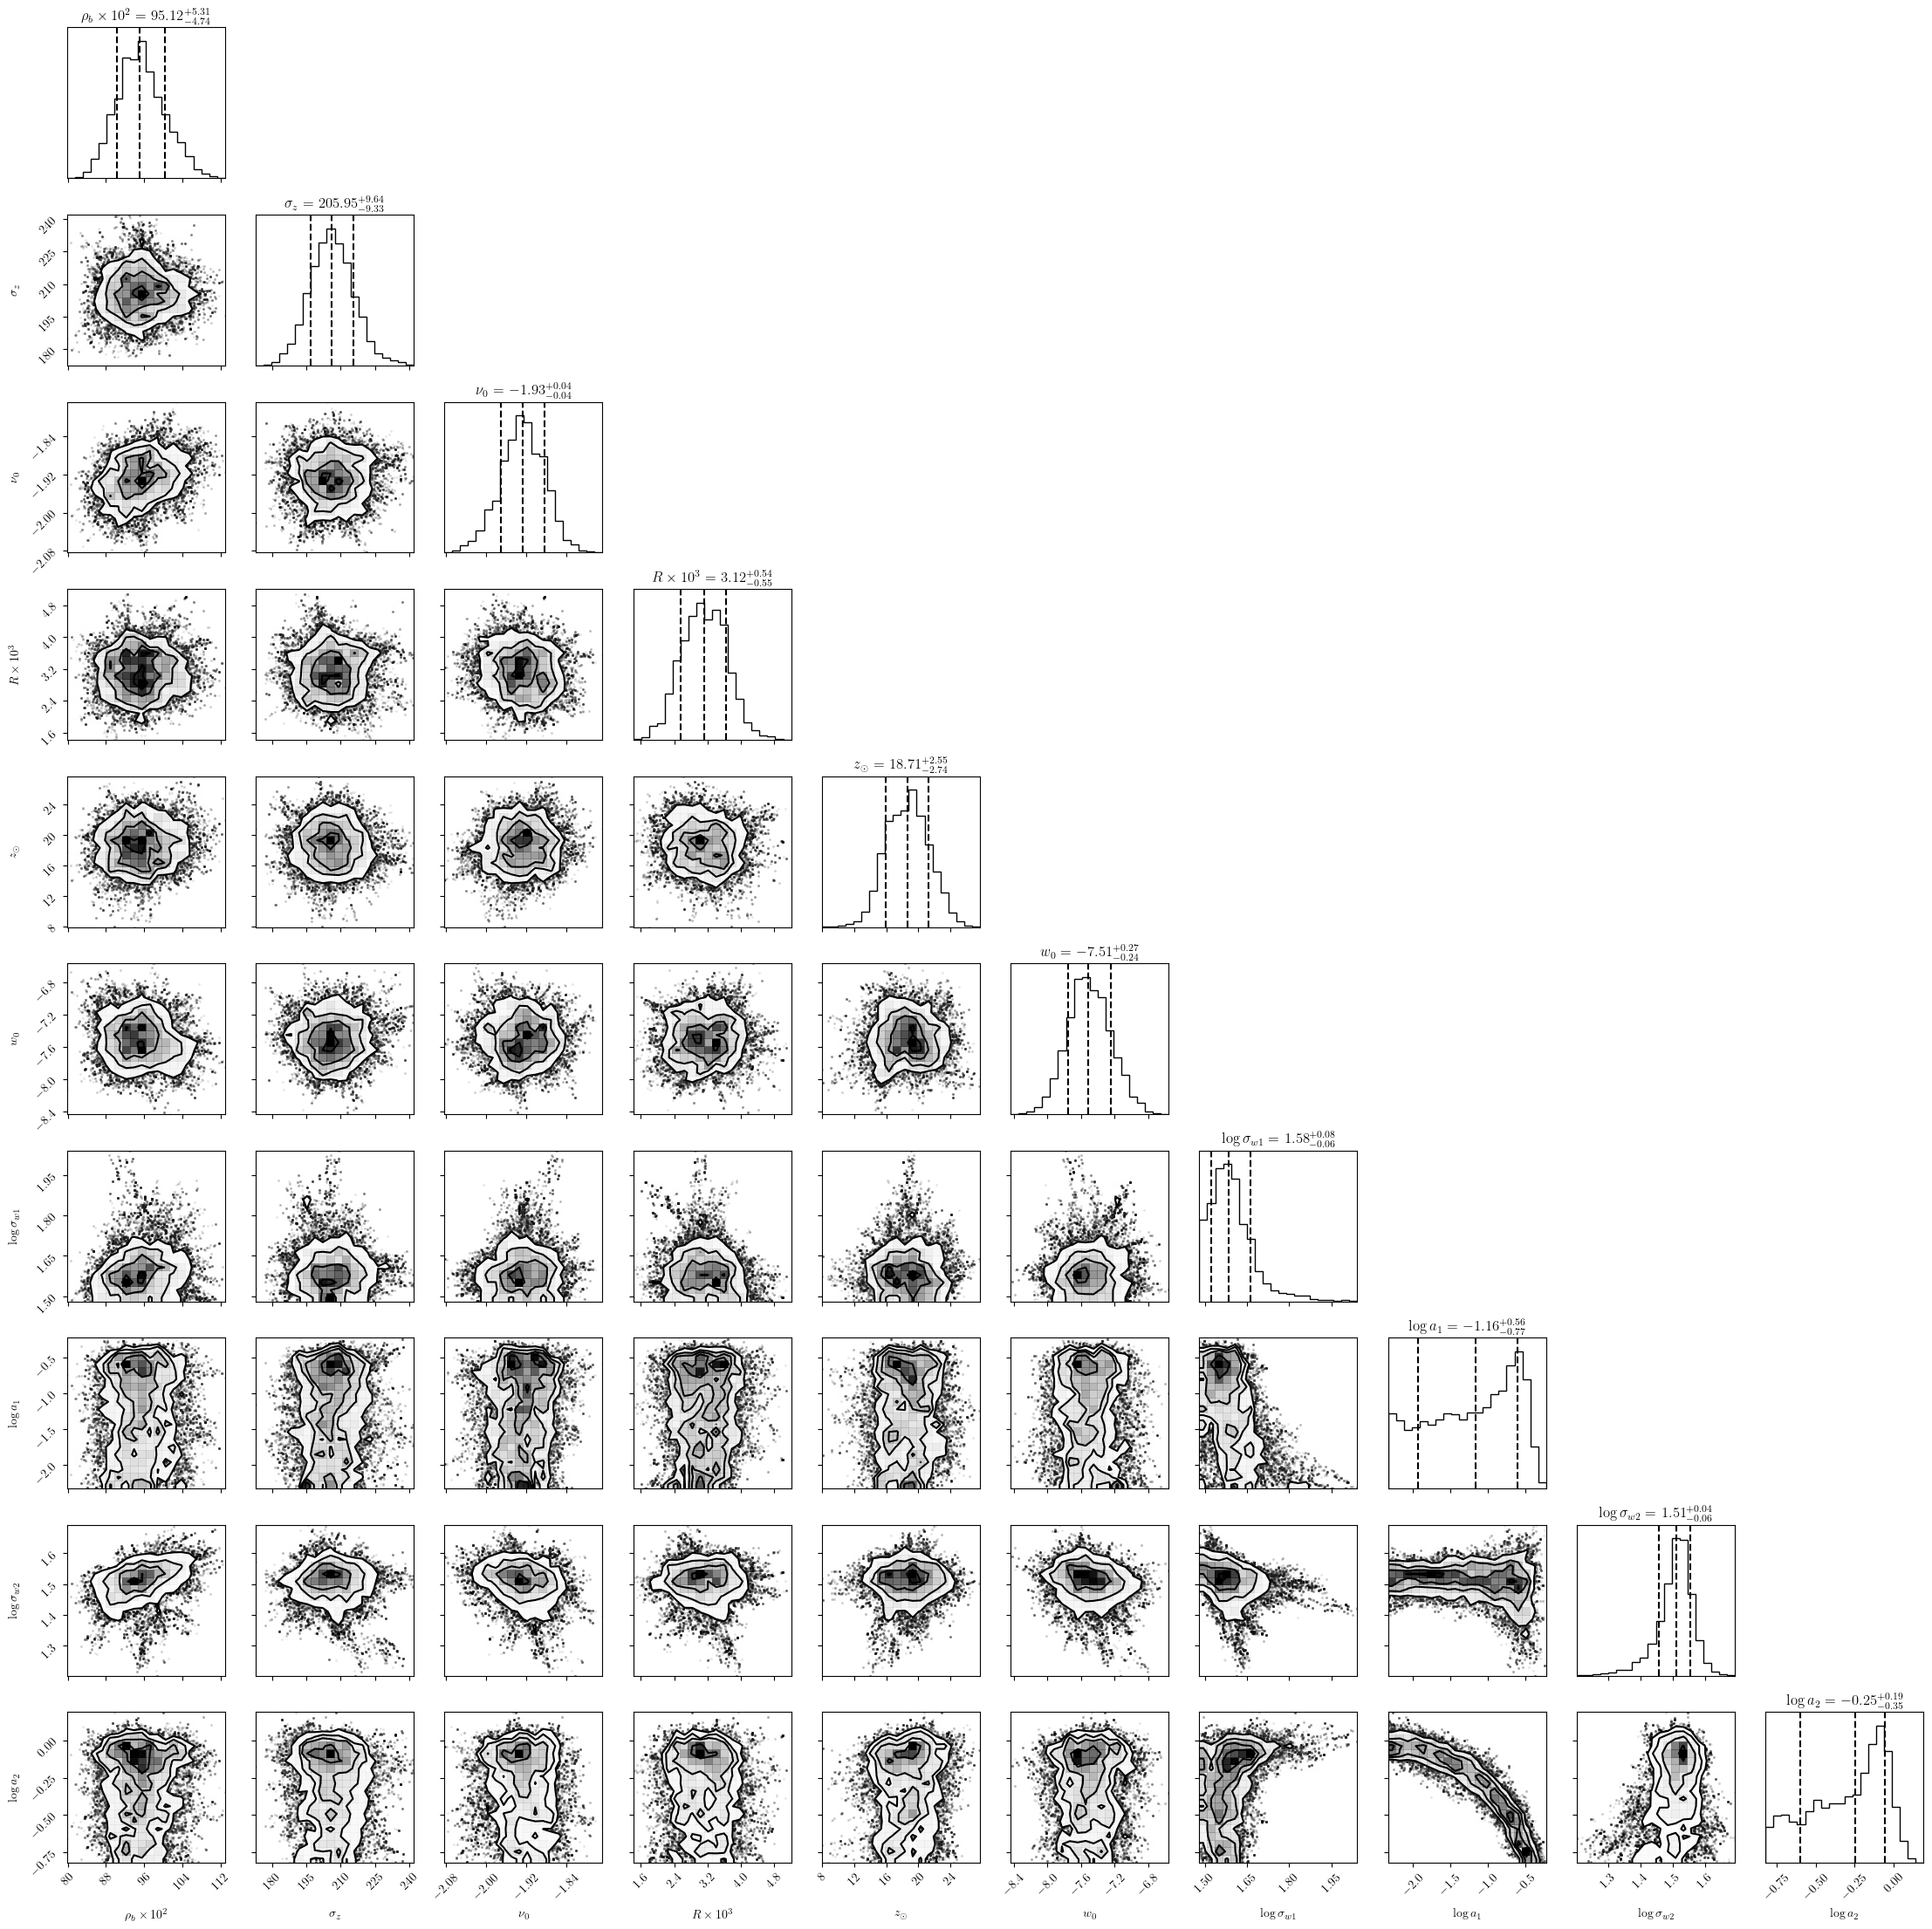

In [34]:
rhob = chain[:, :, :12].sum(axis=2).T/1E-3
sigmaz = chain[:, :, 12:24].sum(axis=2).T
log_nu0 = chain[:, :, 24].T
R = chain[:, :, 25].T/1E-3
zsun = chain[:, :, 26].T
w0 = chain[:, :, 27].T
log_sigmaw1 = chain[:, :, 28].T
log_a1 = chain[:, :, 29].T
log_sigmaw2 = chain[:, :, 30].T
log_a2 = chain[:, :, 31].T

params = np.array([rhob, sigmaz, log_nu0, R, zsun, w0, log_sigmaw1, log_a1, log_sigmaw2, log_a2]).T

labels = [r'$\rho_b\times 10^2$', r'$\sigma_z$', r'$\nu_0$', r'$R\times 10^3$', r'$z_{\odot}$', r'$w_0$', r'$\log \sigma_{w1}$', r'$\log a_1$', r'$\log \sigma_{w2}$', r'$\log a_2$']
utils.plot_corner(params, labels)

100%|██████████| 50000/50000 [00:22<00:00, 2229.21it/s]


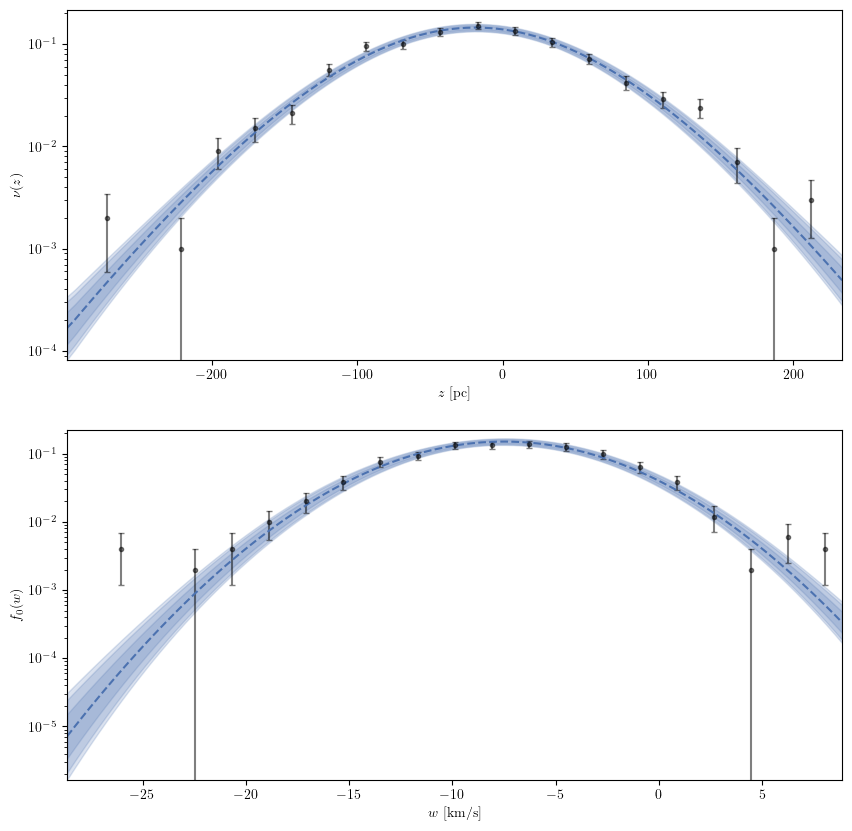

In [36]:
utils.plot_fit(no, zdata, wdata, chain, ndim)